# Benchmark Model

In [50]:
import pandas as pd
from blog.utils.df_utils import split_cols_by_type
from loguru import logger
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from blog.data.data_cleaner_factory import DataCleanerFactory
from blog.model.regularisation import select_features, get_monotone_constraints
from blog.model.optimise import ROCAUCObjective, MultiObjective, PRAUCObjective
from blog.model.evaluation import show_model_results
from blog.data.lendingclub_dataset import LendingClubDataset
from blog.model.sampling import oot_split
from blog.model.regularisation import get_monotone_constraints
from blog.model.feature_transformations import get_simple_feature_transformation
from blog.model.optimise import getObjective, tune_model
from skorecard.bucketers import DecisionTreeBucketer, OrdinalCategoricalBucketer, OptimalBucketer
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline
from skorecard import Skorecard
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

dataset_name = "lendingclub"
target = "loan_status"
path = "../data/lc_2007_2017_selected.csv"


initial_features = [
    "verification_status",
    "emp_title",
    "int_rate",
    "loan_amnt",
    "total_rec_int",
    "total_acc",
    "tot_cur_bal",
    "fico_range_low",
    "fico_range_high",
    "grade",
    "total_rev_hi_lim",
    "sub_grade",
    "initial_list_status",
    "purpose",
    "issue_d",
    "emp_length",
    "pub_rec_bankruptcies",
    "last_pymnt_amnt",
    "num_actv_bc_tl",
    "total_pymnt",
    "loan_status",
    "term",
    "home_ownership",
    "revol_util",
    "application_type",
    "addr_state",
    "inq_last_6mths",
    "pub_rec",
    "dti",
    "mort_acc",
    "revol_bal",
    "title",
    "annual_inc",
    "out_prncp",
    "open_acc",
]

# combine two lists without duplicates
initial_features = list(set(initial_features))
print(initial_features)
# ================== Read and clean the dataset.===========================================
logger.info(f"1.Read data")
lcd = LendingClubDataset()
X, y = lcd.get_data(path=path, use_cols=initial_features, dropna=True, sample=-1)
logger.info(f"\nTarget distribution:\n{y.value_counts(normalize=True)}")

# Split data into IT & OOT datasets.
data = X.copy()
data[target] = y

X_it, y_it, X_oot, y_oot = oot_split(
    df=data, split_date="Jun-2016", split_col="issue_d", target_col=target
)
# Original data dictionary
data_dict= {"xtrain": X_it, "ytrain": y_it, "xtest": X_oot, "ytest": y_oot}

# =================== Apply feature transformation =========================================
logger.info(f"2.Transform features")
# data_dict = get_simple_feature_transformation(data_dict_org)

# =================== Feature Selection =========================================
logger.info(f"3.Starting feature selection.")
# Select the best features based on SHAPRFE CV
# selected_features, fs_plot = select_features(data=data_dict, verbose=100)

selected_features = [
    "emp_length",
    "addr_state",
    "revol_util",
    "revol_bal",
    "term",
    "num_actv_bc_tl",
    "total_acc",
    "application_type",
    "purpose",
    "sub_grade",
    "dti"
]
logger.info(f"Final features :  {selected_features}")
# Update the data dictionary with the selected features.
data_dict["xtrain"] = data_dict["xtrain"][selected_features]
data_dict["xtest"] = data_dict["xtest"][selected_features]


2022-04-11 23:04:28.864 | INFO     | __main__:<module>:74 - 1.Read data


['initial_list_status', 'fico_range_low', 'sub_grade', 'total_acc', 'term', 'application_type', 'fico_range_high', 'mort_acc', 'loan_status', 'emp_length', 'total_rec_int', 'emp_title', 'pub_rec', 'title', 'annual_inc', 'total_pymnt', 'home_ownership', 'total_rev_hi_lim', 'addr_state', 'inq_last_6mths', 'revol_bal', 'tot_cur_bal', 'num_actv_bc_tl', 'verification_status', 'grade', 'purpose', 'open_acc', 'loan_amnt', 'last_pymnt_amnt', 'revol_util', 'out_prncp', 'int_rate', 'dti', 'issue_d', 'pub_rec_bankruptcies']


2022-04-11 23:04:29.270 | INFO     | blog.data.lendingclub_dataset:_read_data:24 - Reading data from path ../data/lc_2007_2017_selected.csv
2022-04-11 23:04:35.776 | INFO     | blog.data.lendingclub_dataset:_read_data:28 - Read data with shape (1646801, 35)
2022-04-11 23:04:38.053 | INFO     | blog.data.lendingclub_dataset:_process_data:72 - Creating target data.
2022-04-11 23:04:43.217 | INFO     | blog.data.lendingclub_dataset:get_data:117 - Shape of training data X :(682278, 34), y : (682278,).
2022-04-11 23:04:43.238 | INFO     | __main__:<module>:77 - 
Target distribution:
0    0.793679
1    0.206321
Name: loan_status, dtype: float64
2022-04-11 23:04:43.688 | INFO     | blog.model.sampling:oot_split:63 - IT data info 
 : {'name': 'IT', 'X_shape': (597837, 35), 'y_shape': (597837,), 'default_rate': 21.097389422200365, 'pct_of_data': 87.6, 'earliest_disbursed_date': Timestamp('2012-08-01 00:00:00'), 'latest_disbursed_date': Timestamp('2016-05-01 00:00:00'), 'default_count': 126128}


### Train a LGB Model

In [51]:
# model_params = tune_model(data_dict["xtrain"], data_dict["ytrain"], "rocauc")

model_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 3.221919143923753e-08,
    "lambda_l2": 0.0016740960905730054,
    "num_leaves": 66,
    "feature_fraction": 0.6,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "min_child_samples": 20,
}


# =================== Train Model =========================================
logger.info(f"5.Train Model ")
logger.info(f"Creating model with params : {model_params}")
mono_lgb = lgb.LGBMClassifier(**model_params)
fitted_mono_lgb = show_model_results(data=data_dict, model=mono_lgb)

2022-04-11 23:04:43.925 | INFO     | __main__:<module>:20 - 5.Train Model 
2022-04-11 23:04:43.927 | INFO     | __main__:<module>:21 - Creating model with params : {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 3.221919143923753e-08, 'lambda_l2': 0.0016740960905730054, 'num_leaves': 66, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}


[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0016740960905730054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016740960905730054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Train ROC-AUC score : 0.7327844256481225
Test ROC-AUC score : 0.6801933705679917
Test PR AUC socre : 0.2961707707568354
Best balanced accouracy of 0.6296590661954442 obtained at threshold 0.21000000000000002 


### Train a LR Model

In [52]:
# Convert string columns to categorical.
cat_cols, num_cols = split_cols_by_type(data_dict["xtrain"])

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=5000))]
)

logger.info(f"6.Calculate LR")
fitted_clf = show_model_results(
    data=data_dict, model=lr, calc_rocauc=True
)


2022-04-11 23:04:48.837 | INFO     | __main__:<module>:22 - 6.Calculate LR


Train ROC-AUC score : 0.7148385980899157
Test ROC-AUC score : 0.677941278300693
Test PR AUC socre : 0.2909452501999185
Best balanced accouracy of 0.6266723831520099 obtained at threshold 0.21000000000000002 


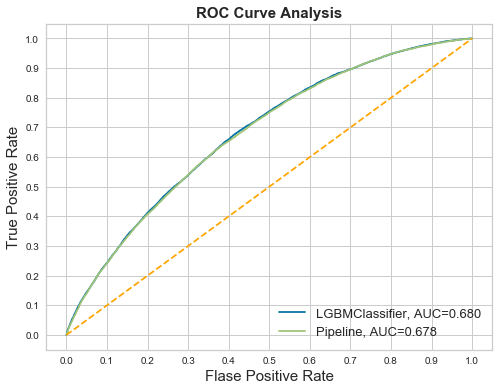

In [53]:
from blog.model.visualisations import plot_roc
plot_roc(models=[fitted_mono_lgb,fitted_clf], data_dict=data_dict)

In [54]:
# Create a validation set, to do the error analysis.
X_train, X_val, y_train, y_val = train_test_split(data_dict["xtrain"], data_dict["ytrain"],test_size=0.3,stratify=data_dict["ytrain"])
lgb_model = mono_lgb.fit(X_train, y_train)
lr_model = lr.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0016740960905730054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016740960905730054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [55]:
lgb_yhat_name = 'p_lgb_loan_status'
lr_yhat_name = 'p_lr_loan_status'

preds_lgb = lgb_model.predict_proba(X_val)[:,1]
preds_lr = lr_model.predict_proba(X_val)[:,1]

X_val_results = X_val.copy().reset_index(drop=True)
X_val_results[lgb_yhat_name] = preds_lgb
X_val_results[lr_yhat_name] = preds_lr
X_val_results[target] = y_val.values

X_val_results.head()

,emp_length,addr_state,revol_util,revol_bal,term,num_actv_bc_tl,total_acc,application_type,purpose,sub_grade,dti,p_lgb_loan_status,p_lr_loan_status,loan_status
0,6.0,ca,91.1,24227.0,36 months,4.0,6.0,individual,home_improvement,f1,27.89,0.318622,0.385369,1
1,7.0,ca,1.5,64.0,36 months,2.0,25.0,individual,debt_consolidation,c5,12.27,0.252134,0.202116,1
2,10.0,ny,33.7,36304.0,36 months,8.0,37.0,individual,debt_consolidation,a3,24.50,0.105009,0.081359,0
3,3.0,ut,23.7,5271.0,36 months,1.0,19.0,individual,debt_consolidation,c1,16.23,0.125583,0.146167,0
4,3.0,nc,72.9,13417.0,36 months,1.0,43.0,individual,debt_consolidation,a4,21.13,0.083772,0.068793,0


In [56]:
valid_yhat_df2 = X_val_results.copy()
cutoff=0.21
# create columns for gbm and glm decisions (i.e. apply cutoff)
valid_yhat_df2['lgb_DECISION'] = 0
valid_yhat_df2.loc[valid_yhat_df2[f'p_lgb_{target}'] > cutoff,
                   'lgb_DECISION'] = 1

valid_yhat_df2['lr_DECISION'] = 0
valid_yhat_df2.loc[valid_yhat_df2[f'p_lr_{target}'] > cutoff,
                   'lr_DECISION'] = 1

# create columns for gbm and glm wrong decisions
valid_yhat_df2['lgb_WRONG'] = 0
valid_yhat_df2.loc[valid_yhat_df2[target] != valid_yhat_df2['lgb_DECISION'], 'lgb_WRONG'] = 1
valid_yhat_df2['lr_WRONG'] = 0
valid_yhat_df2.loc[valid_yhat_df2[target] != valid_yhat_df2['lr_DECISION'], 'lr_WRONG'] = 1

# create a subset of preds where LGB is wrong, but LR is right
gbm_wrong = valid_yhat_df2.loc[(valid_yhat_df2['lgb_WRONG'] == 1) & 
                               (valid_yhat_df2['lr_WRONG'] == 0)]

gbm_wrong.head()
#gbm_wrong[x_names + [y_name, 'p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH']].head()

,emp_length,addr_state,revol_util,revol_bal,term,num_actv_bc_tl,total_acc,application_type,purpose,sub_grade,dti,p_lgb_loan_status,p_lr_loan_status,loan_status,lgb_DECISION,lr_DECISION,lgb_WRONG,lr_WRONG
47,0.0,md,71.0,17331.0,36 months,3.0,24.0,individual,debt_consolidation,c1,21.84,0.217461,0.202611,0,1,0,1,0
117,9.0,ny,64.6,8782.0,36 months,3.0,40.0,individual,other,b5,27.07,0.248517,0.188543,0,1,0,1,0
147,6.0,ca,43.5,7046.0,36 months,5.0,21.0,individual,debt_consolidation,c2,12.83,0.213250,0.188385,0,1,0,1,0
152,1.0,or,96.5,4054.0,36 months,1.0,11.0,individual,debt_consolidation,c3,18.44,0.234423,0.161307,0,1,0,1,0
225,8.0,hi,56.7,850.0,36 months,2.0,17.0,individual,other,c5,12.48,0.214430,0.181203,0,1,0,1,0


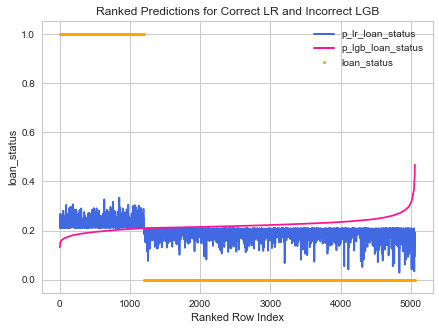

In [57]:
# custom legend
from matplotlib.lines import Line2D
%matplotlib inline 
custom = [Line2D([0], [0], color='royalblue', lw=2),
          Line2D([0], [0], color='deeppink', lw=2),
          Line2D([0], [0], marker='o', color='w',
          markerfacecolor='orange', markersize=3)]

# init plot
fig, ax = plt.subplots(figsize=(7, 5)) 

# plot sorted actuals
# double index reset orders index by sort variable and
# brings index into frame for plotting
_ = gbm_wrong[[target,f"p_lgb_{target}"]].\
            sort_values(by=f"p_lgb_{target}").\
            reset_index(drop=True).\
            reset_index().\
            plot(kind='scatter', x='index', y=target, color='orange', s=3, ax=ax, 
                 legend=False)

# plot sorted gbm and glm preds 
_ = gbm_wrong[[f"p_lr_{target}", f"p_lgb_{target}"]].\
            sort_values(by=f"p_lgb_{target}").\
            reset_index(drop=True).\
            plot(ax=ax, legend=False, color=['royalblue','deeppink'],
                 title='Ranked Predictions for Correct LR and Incorrect LGB')

# annotate plot
_ = ax.legend(custom, [f"p_lr_{target}", f"p_lgb_{target}", target])
_ = ax.set_xlabel('Ranked Row Index')

In [58]:
gbm_wrong[X_val.columns].describe()

,emp_length,revol_util,revol_bal,num_actv_bc_tl,total_acc,dti
count,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000
mean,5.960474,57.061858,18837.167194,3.796838,26.211462,17.751302
std,3.768769,27.129510,33533.926704,2.412868,14.543755,8.091437
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.160000
25%,2.000000,39.200000,5033.500000,2.000000,16.000000,11.427500
50%,7.000000,57.500000,10025.500000,3.000000,24.000000,17.785000
75%,10.000000,76.000000,19138.250000,5.000000,33.000000,23.590000
max,10.000000,892.300000,476534.000000,19.000000,156.000000,43.360000


In [59]:
from sklearn.metrics import classification_report
print(classification_report(list(valid_yhat_df2['lgb_DECISION'].values), 
                            list(valid_yhat_df2['lr_DECISION'].values)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95    102757
           1       0.92      0.94      0.93     76595

    accuracy                           0.94    179352
   macro avg       0.94      0.94      0.94    179352
weighted avg       0.94      0.94      0.94    179352

